<a href="https://colab.research.google.com/github/karthiklakkur1/Crop-weed-extension/blob/main/medicinalplantdataset_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishnuoum/medicinal-plant-dataset-augmented")

print("Path to dataset files:", path)

100%|██████████| 1.31G/1.31G [00:18<00:00, 74.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vishnuoum/medicinal-plant-dataset-augmented/versions/1


In [2]:
import shutil

# Source: dataset path from kagglehub
src_path = "/root/.cache/kagglehub/datasets/vishnuoum/medicinal-plant-dataset-augmented/versions/1"

# Destination: your desired folder in Google Drive
dst_path = "/content/drive/MyDrive/medicinal-plant-dataset"

# Copy the dataset recursively
shutil.copytree(src_path, dst_path)


'/content/drive/MyDrive/medicinal-plant-dataset'

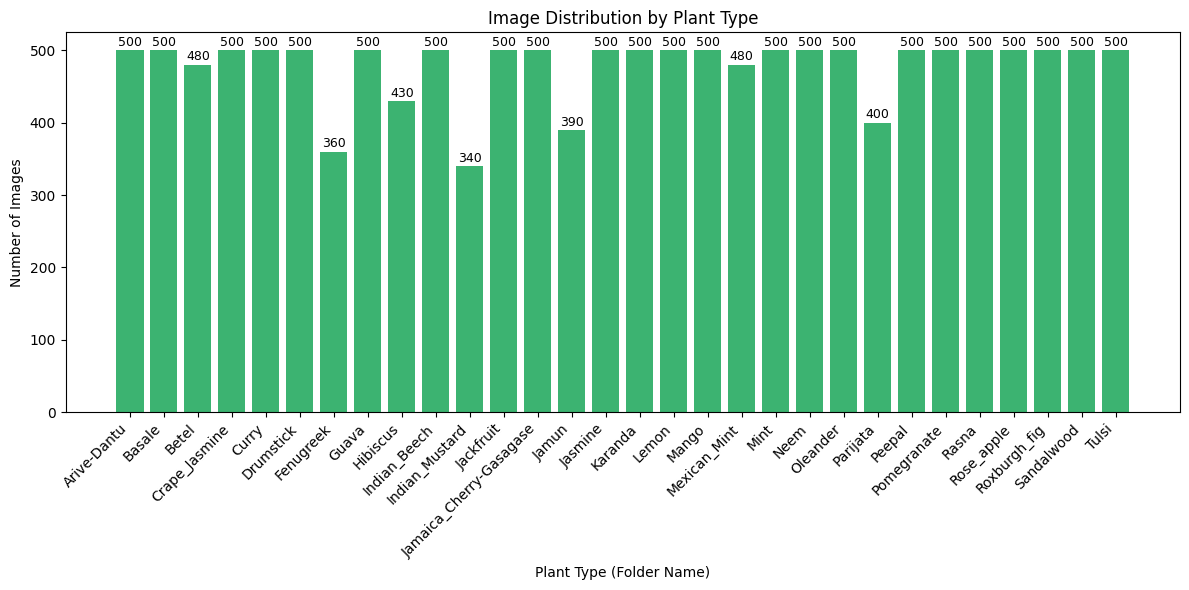

In [3]:
import os
import matplotlib.pyplot as plt

# Path to your dataset folders inside Google Drive
dataset_path = '/content/drive/MyDrive/medicinal-plant-dataset/data'

# Get folder names and image counts
class_names = []
image_counts = []

for folder_name in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_names.append(folder_name)
        image_counts.append(num_images)

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, image_counts, color='mediumseagreen')
plt.xlabel('Plant Type (Folder Name)')
plt.ylabel('Number of Images')
plt.title('Image Distribution by Plant Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, str(height), ha='center', va='bottom', fontsize=9)

plt.show()


In [4]:
import os
import shutil
import random

def split_and_move_images(src_dir, target_dir, split_ratios=(0.7, 0.15, 0.15), seed=42):
    os.makedirs(target_dir, exist_ok=True)
    train_dir = os.path.join(target_dir, 'train')
    test_dir = os.path.join(target_dir, 'test')
    val_dir = os.path.join(target_dir, 'val')

    for d in [train_dir, test_dir, val_dir]:
        os.makedirs(d, exist_ok=True)

    images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.seed(seed)
    random.shuffle(images)

    total = len(images)
    train_end = int(split_ratios[0] * total)
    val_end = train_end + int(split_ratios[1] * total)

    subsets = {
        train_dir: images[:train_end],
        val_dir: images[train_end:val_end],
        test_dir: images[val_end:]
    }

    for subset_path, subset_images in subsets.items():
        for img in subset_images:
            shutil.copy2(os.path.join(src_dir, img), os.path.join(subset_path, img))

# Paths setup
base_path = '/content/drive/MyDrive/medicinal-plant-dataset/data'
output_base = '/content/drive/MyDrive/medicinal-plant-dataset/split'

for class_name in ['Mint', 'Indian_Mustard']:
    src_class_path = os.path.join(base_path, class_name)
    dst_class_path = os.path.join(output_base, class_name)
    split_and_move_images(src_class_path, dst_class_path)


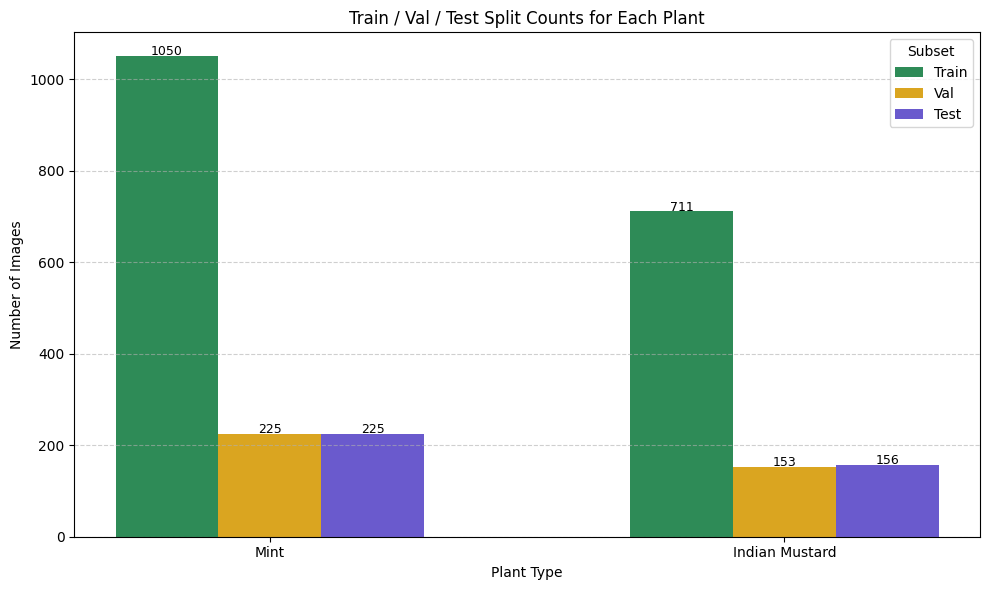

In [14]:
import os
import matplotlib.pyplot as plt

# Paths and setup
split_base = '/content/drive/MyDrive/medicinal-plant-dataset/split'
plant_types = ['Mint', 'Indian_Mustard']
splits = ['train', 'val', 'test']
colors = ['seagreen', 'goldenrod', 'slateblue']  # consistent ordering for T/V/T

# Collect data
bar_data = []  # each item is a list of [train, val, test] for one plant
for plant in plant_types:
    split_counts = []
    for split in splits:
        split_path = os.path.join(split_base, plant, split)
        count = len([
            f for f in os.listdir(split_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        split_counts.append(count)
    bar_data.append(split_counts)

# Plotting
bar_width = 0.2
x = range(len(plant_types))
x_positions = []

plt.figure(figsize=(10, 6))

for i, split in enumerate(splits):
    # Offset bars for train, val, and test within each plant group
    x_pos = [xi + i * bar_width for xi in x]
    x_positions.append(x_pos)
    split_counts = [bar_data[p][i] for p in range(len(plant_types))]
    plt.bar(x_pos, split_counts, width=bar_width, color=colors[i], label=split.title())

    # Add labels
    for xp, count in zip(x_pos, split_counts):
        plt.text(xp, count + 2, str(count), ha='center', fontsize=9)

# Final styling
plant_labels = [name.replace('_', ' ').title() for name in plant_types]
midpoints = [xi + bar_width for xi in x]  # center of each group
plt.xticks(midpoints, plant_labels)
plt.xlabel('Plant Type')
plt.ylabel('Number of Images')
plt.title('Train / Val / Test Split Counts for Each Plant')
plt.legend(title='Subset')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tqdm import tqdm

# Define augmentation settings
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3),
    fill_mode='nearest'
)

def augment_and_save_images(image_dir, augment_count=2):
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in tqdm(image_files, desc=f'Augmenting in {os.path.basename(image_dir)}'):
        img_path = os.path.join(image_dir, img_file)
        try:
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            gen = datagen.flow(x, batch_size=1)
            base_name, ext = os.path.splitext(img_file)

            for i in range(augment_count):
                aug = next(gen)[0].astype('uint8')
                new_img = array_to_img(aug)
                new_img.save(os.path.join(image_dir, f"{base_name}_aug{i+1}{ext}"))

        except Exception as e:
            print(f"❌ Failed to augment {img_file}: {e}")

# === Apply to mint and indian_mustard in train/val/test ===
base_path = '/content/drive/MyDrive/medicinal-plant-dataset/split'
plants = ['Mint', 'Indian_Mustard']
splits = ['train', 'val', 'test']

for plant in plants:
    for split in splits:
        img_dir = os.path.join(base_path, plant, split)
        augment_and_save_images(img_dir, augment_count=2)


Augmenting in test: 100%|██████████| 52/52 [00:11<00:00,  4.67it/s]
